## First Go at Classification Using a Convolutional Neural Network

In our EDA, we saw that there is a variety of sizes, color modes, and class sizes within our dataset. This means we will likely need to do some preprocessing on our data before creating a classification algorithm. Luckily, TensorFlow has many in-built functions which take care of most of these steps for us. Before adding augmentation, it is good to perform a baseline test of how well a classification model performs on a dataset. Let's now go ahead and create a simple convolutional neural network using TensorFlow!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
!ls

CNN_classifier.ipynb         arcDataset
EDA.ipynb                    architectural-styles-dataset
README.md                    rgb-dataset


First of all, let's load up the data using a Keras utility.

In [3]:
batch_size = 64
img_height = 800
img_width = 800
data_dir = 'rgb-dataset'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Now it's time to decide on a model architecture! 

My first thought was to emulate the famous LeNet-5 architecture, which consists of a series of convolutional and pooling layers followed by fully connected layers. Firstly, we there are three convolutional layers using 5x5 kernels with 6, 16, and 120 channels. The activation function used is the hyperbolic tangent (tanh). Between the first two and second two layers are average pooling layers with sigmoid activations. After these layers, the output is flattened, and fed through two fully-connected layers of sizes 84 and 10 with tanh and SoftMax activations respectively.

LeNet-5 was groundbreaking in its time and laid the foundation for modern CNNs. However, to adapt to the complexities of contemporary computer vision tasks and leverage the advancements in deep learning, I decided to modernize the architecture. The updated design incorporates smaller 3x3 convolutional kernels, which are computationally less expensive than the larger 5x5 filters used by LeNet. Furthermore, the 3x3 kernel already incorporates all the directional information that a larger filter can. Such a kernel will also feature fewer trainable parameters, and may help reduce overfitting.

Additionally, it replaces average pooling with max pooling, which effectively retains only the dominant features. This makes sense for architectural classification, as each style has a few dominant characteristics which already allow us to recognize it (eg classical style can be recognized through columsn, modernism through bare walls).

Finally, I replaced all the activation functions apart from SoftMax with ReLU. At first, this was purely due to computational limitations as I was running the training on my laptop. However, I realized that ReLUs also seem to make more sense if we think about the biological inspiration for neural networks. We can imagine a neuron inside a human brain that would only "fire" if an ionic signal with enough voltage comes its way, much like an on-off switch. In this sense, we have some biological plausibility for using ReLUs in artificial neural networks, whereas it is difficult to think of any natural mechanism to reproduce the behavior of sigmoid or hyperbolic tangent functions.

With these changes in mind, I am ready to define the model architecture with Keras:

In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(120, 3, padding='same', activation='relu'),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
    
  layers.Dense(num_classes, activation='softmax')
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 120)       3

In [11]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

127/127 [==============================] - 323s 3s/step - loss: 3.4621 - accuracy: 0.0884 - val_loss: 3.0282 - val_accuracy: 0.1227


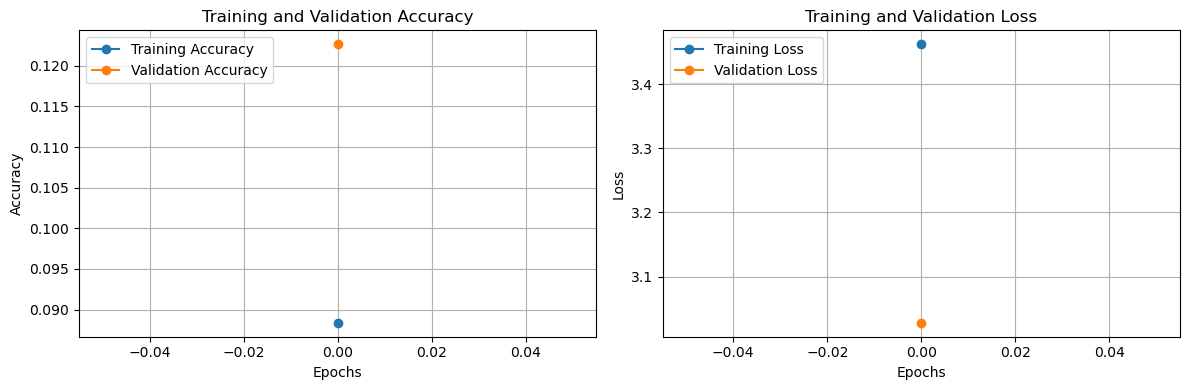

In [12]:
# Extract the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(epochs_range, acc, label='Training Accuracy', marker='o', linestyle='-')
axs[0].plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', linestyle='-')
axs[0].legend(loc='upper left')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].grid(True)

axs[1].plot(epochs_range, loss, label='Training Loss', marker='o', linestyle='-')
axs[1].plot(epochs_range, val_loss, label='Validation Loss', marker='o', linestyle='-')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].grid(True)

plt.tight_layout()

plt.show()


We can see that the training loss consistenly decreases while training accuracy increases. This is exactly what we hope to achieve in machine learning! However, we can also see that the story is very different for our validation data. The validation accuracy stays flat while the loss keeps increasing. So what is going on? Well, this is a problem known as overfitting. This indicates that while the model can learn to classify images in the training dataset very well, it is unable to generalize to images it has not seen before. This indicates that we should explore techniques to avoid this, and luckily TensorFlow has many functions that can do this for us!

Let's do some augmentation. We can define this using Keras preprocessing layers, which we can then include in our model. The goal is to use augmentations which would still give us believable and relevant images, so we won't use vertical flips in this case, as we would not expect to ever see an upside down building!

In [13]:
augmentations = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [14]:
num_classes = len(class_names)

improved_model = Sequential([
  augmentations,
    
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(120, 3, padding='same', activation='relu'),
    
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
    
  layers.Dense(num_classes, activation='softmax')
])

In [15]:
improved_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
improved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [17]:
epochs = 15
history = improved_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
127/127 [==============================] - 307s 2s/step - loss: 3.5386 - accuracy: 0.0749 - val_loss: 3.0419 - val_accuracy: 0.1286
Epoch 2/15
127/127 [==============================] - 312s 2s/step - loss: 2.9586 - accuracy: 0.1397 - val_loss: 2.8430 - val_accuracy: 0.1691
Epoch 3/15
127/127 [==============================] - 313s 2s/step - loss: 2.8131 - accuracy: 0.1665 - val_loss: 2.7491 - val_accuracy: 0.1805
Epoch 4/15
127/127 [==============================] - 330s 3s/step - loss: 2.7120 - accuracy: 0.1931 - val_loss: 2.7601 - val_accuracy: 0.1988
Epoch 5/15
127/127 [==============================] - 302s 2s/step - loss: 2.6066 - accuracy: 0.2148 - val_loss: 2.6682 - val_accuracy: 0.2196
Epoch 6/15
127/127 [==============================] - 301s 2s/step - loss: 2.5272 - accuracy: 0.2369 - val_loss: 2.6439 - val_accuracy: 0.2349
Epoch 7/15
127/127 [==============================] - 337s 3s/step - loss: 2.4507 - accuracy: 0.2610 - val_loss: 2.6481 - val_accuracy: 0.2552

KeyboardInterrupt: 

In [ ]:
# Extract the training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(epochs_range, acc, label='Training Accuracy', marker='o', linestyle='-')
axs[0].plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', linestyle='-')
axs[0].legend(loc='upper left')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].grid(True)

axs[1].plot(epochs_range, loss, label='Training Loss', marker='o', linestyle='-')
axs[1].plot(epochs_range, val_loss, label='Validation Loss', marker='o', linestyle='-')
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].grid(True)

plt.tight_layout()

plt.show()
